## Minimal viable product

Target variable: 
* mortality secondary to myocardial infarction per month per state

Predictor variables: 
* obesity prevalence and diabetes prevalence as percentage per state
* initially given as annual data, upsampled to monthly frequency

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

# create autocorr plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # better and more arguments

%matplotlib inline

The target variable is myocardial infarction by state.

In [2]:
%%bash
ls ../data/pickles

cardiac_mortality_obesity_dm_df_by_state.pkl
myocardial_infarction_df_state_mortality_dict.pkl


In [3]:
with open("../data/pickles/myocardial_infarction_df_state_mortality_dict.pkl", "rb") as picklefile:
    df, state_mortality_dict = pickle.load(picklefile)

In [4]:
df.head()

,Notes,State,State Code,Month,Month Code,Deaths,Population,Crude Rate
0,,Alabama,01,1999-01-01,1999/01,332.0,Not Applicable,Not Applicable
1,,Alabama,01,1999-02-01,1999/02,332.0,Not Applicable,Not Applicable
2,,Alabama,01,1999-03-01,1999/03,377.0,Not Applicable,Not Applicable
3,,Alabama,01,1999-04-01,1999/04,301.0,Not Applicable,Not Applicable
4,,Alabama,01,1999-05-01,1999/05,314.0,Not Applicable,Not Applicable


The predictor variables that I have available and that are actually clean are the ones supplied by the CDC diabetes atlas. So, we'll start with those.

In [57]:
def clean_up_xlsx(df):
    new_df = df.copy()
    beginning_cols = ['State', 'FIPS Codes', 'County']
    years = [year for year in list(df.columns) if type(year) == int]
    first_row = list(df.iloc[0])
    first_row_filtered = [elem for elem in first_row if elem not in ['State', 'FIPS Codes', 'County']]
    number_of_fields_to_append_year = len(set(first_row_filtered))
    
    new_columns = beginning_cols
    
    for year in years:
        mini_list = [str(year) + " " + elem for elem in first_row_filtered[0:number_of_fields_to_append_year]]
        first_row_filtered = first_row_filtered[number_of_fields_to_append_year:]
        new_columns.extend(mini_list)
    
    df_rename_columns = dict(zip(df.columns, new_columns))
    
    new_df.rename(columns=df_rename_columns, inplace=True)
    new_df.drop([0], inplace=True)
    
    return new_df

In [56]:
dm_incidence = pd.read_excel("../data/cdc_diabetes/INCIDENCE_ALL_STATES.xlsx")

In [58]:
dm_incidence_by_county_df = clean_up_xlsx(dm_incidence)

In [59]:
dm_incidence_by_county_df.head()

,State,FIPS Codes,County,2004 number of new cases,2004 rate per 1000,2004 lower confidence limit,2004 upper confidence limit,2004 age-adjusted rate per 1000,2004 age-adjusted lower confidence limit,2004 age-adjusted upper confidence limit,...,2012 age-adjusted rate per 1000,2012 age-adjusted lower confidence limit,2012 age-adjusted upper confidence limit,2013 number of new cases,2013 rate per 1000,2013 lower confidence limit,2013 upper confidence limit,2013 age-adjusted rate per 1000,2013 age-adjusted lower confidence limit,2013 age-adjusted upper confidence limit
1,Alabama,01001,Autauga County,425,14.2,9.8,19.6,14.4,9.9,20,...,10.2,7.1,14.2,383,11,8.2,14.3,10.7,7.9,14
2,Alabama,01003,Baldwin County,1103,10.3,7.3,13.9,9.6,6.8,13,...,7.7,5.5,10.5,1078,8.1,6.4,10.1,7.4,5.7,9.2
3,Alabama,01005,Barbour County,261,13.2,8.7,18.7,13.3,8.8,18.8,...,14.3,9.9,19.9,291,17,12.5,22.8,16.6,12.1,22.5
4,Alabama,01007,Bibb County,178,12.4,8.6,17.5,12.8,8.9,18,...,11.4,8,15.8,193,13.1,9.3,17.3,12.8,9.1,17.1
5,Alabama,01009,Blount County,403,11,7.4,15.3,10.9,7.4,15.2,...,10.9,7.3,16.1,433,11.7,8.4,15.5,11,7.8,14.8


Except that what you actually want is all of these indicators per state, not per county. These indicators are available at a state level by year, but unfortunately it looks like I'm going to have to download these manually.

We'll use the diabetes prevalence and obesity prevalence per state per year as two predictor variables for the target time series.

In [11]:
%%bash
ls ../data/cdc_diabetes/

DM_PREV_ALL_STATES.xlsx
DM_PREV_by_sex_ALL_STATES.xlsx
INCIDENCE_ALL_STATES.xlsx
LTPIA_PREV_ALL_STATES.xlsx
LTPIA_PREV_by_sex_ALL_STATES.xlsx
OB_PREV_ALL_STATES.xlsx
OB_PREV_by_sex_ALL_STATES.xlsx
state_diabetes_prevalence
state_obesity_prevalence
state_populations_by_year.txt


In [12]:
%%bash
ls ../data/cdc_diabetes/state_diabetes_prevalence/

diabetes_prevalence_1999.csv
diabetes_prevalence_2000.csv
diabetes_prevalence_2001.csv
diabetes_prevalence_2002.csv
diabetes_prevalence_2003.csv
diabetes_prevalence_2004.csv
diabetes_prevalence_2005.csv
diabetes_prevalence_2006.csv
diabetes_prevalence_2007.csv
diabetes_prevalence_2008.csv
diabetes_prevalence_2009.csv
diabetes_prevalence_2010.csv
diabetes_prevalence_2011.csv
diabetes_prevalence_2012.csv
diabetes_prevalence_2013.csv
diabetes_prevalence_2014.csv
diabetes_prevalence_2015.csv


In [13]:
states = list(state_mortality_dict.keys())

In [14]:
years = list(range(1999, 2016))

In [15]:
dm_prevalence_dict = {}

for year in years:
    if year == 2014 or year == 2015:
        dm_prevalence_state_df = pd.read_csv(f"../data/cdc_diabetes/state_diabetes_prevalence/diabetes_prevalence_{year}.csv", sep="\t")
    else:
        dm_prevalence_state_df = pd.read_csv(f"../data/cdc_diabetes/state_diabetes_prevalence/diabetes_prevalence_{year}.csv")
    
    dm_prevalence_state_df['Percentage'] = pd.to_numeric(dm_prevalence_state_df['Percentage'], errors='coerce')
    
    for state in states:
        if state in dm_prevalence_dict:
            dm_prevalence_dict[state].append(float(dm_prevalence_state_df[dm_prevalence_state_df.State == state]['Percentage']))
        else:
            dm_prevalence_dict[state] = [float(dm_prevalence_state_df[dm_prevalence_state_df.State == state]['Percentage'])]

In [16]:
for state, series in dm_prevalence_dict.items():
    temp = dict(zip(pd.to_datetime(years, format='%Y'), series))
    dm_prevalence_dict[state] = pd.Series(temp)

Let's parse the obesity prevalence files.

In [18]:
obesity_prevalence_dict = {}

for year in years:
    obesity_prevalence_state_df = pd.read_csv(f"../data/cdc_diabetes/state_obesity_prevalence/obesity_prevalence_{year}.csv")
    
    obesity_prevalence_state_df['Percentage'] = pd.to_numeric(obesity_prevalence_state_df['Percentage'], errors='coerce')
    
    for state in states:
        if state in obesity_prevalence_dict:
            obesity_prevalence_dict[state].append(float(obesity_prevalence_state_df[obesity_prevalence_state_df.State == state]['Percentage']))
        else:
            obesity_prevalence_dict[state] = [float(obesity_prevalence_state_df[obesity_prevalence_state_df.State == state]['Percentage'])]

In [19]:
for state, series in obesity_prevalence_dict.items():
    temp = dict(zip(pd.to_datetime(years, format='%Y'), series))
    obesity_prevalence_dict[state] = pd.Series(temp)

We need to resample the diabetes and obesity prevalence time series so that there is a data point for every month, in order to match the frequency of our target variable (total deaths due to myocardial infarction) which is sampled monthly.

In [24]:
dm_prevalence_resampled_dict = {}

for state, time_series in dm_prevalence_dict.items():
    resampled_ts = time_series.resample("M").ffill(limit=1).interpolate('linear')
    resampled_ts.index = resampled_ts.index - pd.offsets.MonthBegin(0) - pd.DateOffset(months=1)
    dm_prevalence_resampled_dict[state] = resampled_ts

In [25]:
obesity_prevalence_resampled_dict = {}

for state, time_series in obesity_prevalence_dict.items():
    resampled_ts = time_series.resample("M").ffill(limit=1).interpolate('linear')
    resampled_ts.index = resampled_ts.index - pd.offsets.MonthBegin(0) - pd.DateOffset(months=1)
    obesity_prevalence_resampled_dict[state] = resampled_ts

In [26]:
dict_of_dfs = {}

for state, cardiac_mortality_df in state_mortality_dict.items():
    temp_df = cardiac_mortality_df.copy()
    temp_df['obesity_prevalence'] = obesity_prevalence_resampled_dict[state]
    temp_df['diabetes_prevalence'] = dm_prevalence_resampled_dict[state]
    dict_of_dfs[state] = temp_df

Let's also import the state populations by year and then normalize the mortality rate by state population by year.

In [27]:
%%bash
ls ../data/cdc_diabetes/

DM_PREV_ALL_STATES.xlsx
DM_PREV_by_sex_ALL_STATES.xlsx
INCIDENCE_ALL_STATES.xlsx
LTPIA_PREV_ALL_STATES.xlsx
LTPIA_PREV_by_sex_ALL_STATES.xlsx
OB_PREV_ALL_STATES.xlsx
OB_PREV_by_sex_ALL_STATES.xlsx
state_diabetes_prevalence
state_obesity_prevalence
state_populations_by_year.txt


In [28]:
with open("../data/cdc_diabetes/state_populations_by_year.txt", "r") as f:
    lines = f.readlines()

In [29]:
state_population_by_year = pd.read_csv("../data/cdc_diabetes/state_populations_by_year.txt", delimiter="\t")
state_population_by_year = state_population_by_year[['State', 'State Code', 'Year', 'Population']]
state_population_by_year.dropna(inplace=True)

state_population_by_year['Year'] = state_population_by_year['Year'].apply(int)
state_population_by_year['Year'] = pd.to_datetime(state_population_by_year['Year'], format='%Y')
state_population_by_year['Population'] = pd.to_numeric(state_population_by_year['Population'])

In [30]:
grouped_by_state = state_population_by_year.groupby('State')[['Year', 'Population']]

In [31]:
state_population_by_year_dict = {}

for state in states:
    temp = grouped_by_state.get_group(state).set_index('Year')
    temp = temp.resample("M").ffill(limit=1).interpolate('linear')
    temp.index = temp.index - pd.offsets.MonthBegin(0) - pd.DateOffset(months=1)
    state_population_by_year_dict[state] = temp

In [32]:
for state in states:
    temp_df = dict_of_dfs[state].copy()
    temp_df['Population'] = state_population_by_year_dict[state]
    temp_df['mortality_per_100k'] = 100000*(temp_df['Deaths']/temp_df['Population'])
    dict_of_dfs[state] = temp_df

In [61]:
with open("../data/pickles/state_population_by_year_dict.pkl", "wb") as picklefile:
    pickle.dump(state_population_by_year_dict, picklefile)

In [62]:
%%bash
ls ../data/pickles

cardiac_mortality_obesity_dm_df_by_state.pkl
myocardial_infarction_df_state_mortality_dict.pkl
state_population_by_year_dict.pkl


In [34]:
with open("../data/pickles/cardiac_mortality_obesity_dm_df_by_state.pkl", "wb") as picklefile:
    pickle.dump(dict_of_dfs, picklefile)

## Modeling

I now have a dataframe for each state; dict_of_dicts has a key for each state, and the value is the dataframe for that state. For now, we'll drop all the rows with NaNs in them.

In [38]:
for state, df in dict_of_dfs.items():
    dict_of_dfs[state] = df.dropna()

In [55]:
dict_of_dfs['Alabama'].head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,332.0,61.400000,7.400000,4430141.00,7.494118
1999-02-01,332.0,60.833333,7.383333,4431554.25,7.491728
1999-03-01,377.0,60.266667,7.366667,4432967.50,8.504461
1999-04-01,301.0,59.700000,7.350000,4434380.75,6.787870
1999-05-01,314.0,59.133333,7.333333,4435794.00,7.078778


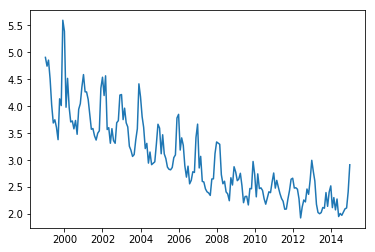

In [39]:
state = 'California'

plt.plot(dict_of_dfs[state]['mortality_per_100k'])
plt.show()

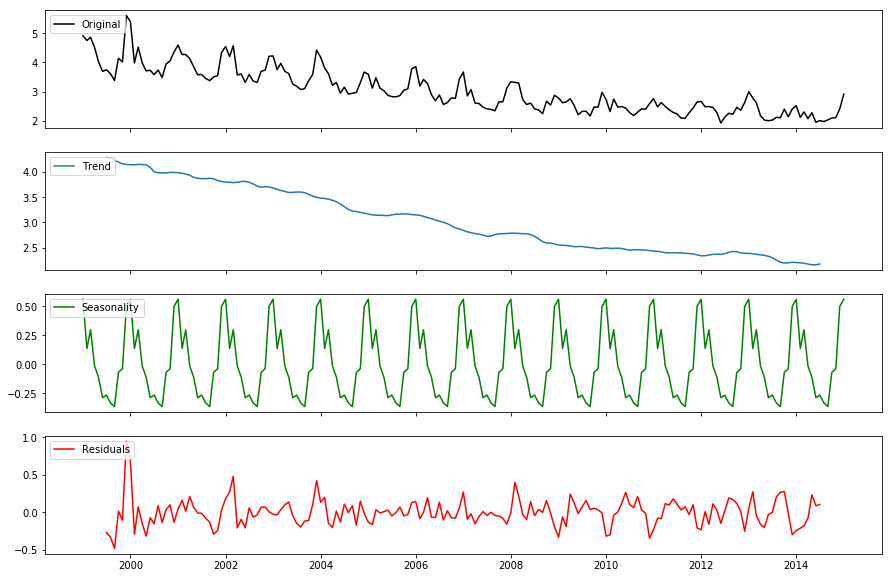

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=dict_of_dfs[state].mortality_per_100k, 
                                      model='additive')
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(dict_of_dfs[state].mortality_per_100k, 'k', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, 'g', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual, 'r', label='Residuals')
axes[3].legend(loc='upper left')

In [50]:
print(dict_of_dfs[state].Deaths.std())
print(dict_of_dfs[state].Deaths.diff().std())
dict_of_dfs[state].Deaths.diff().diff().std()

233.12695555676862
113.3073761546699


170.1910250560955

Figure(432x288)
Figure(432x288)


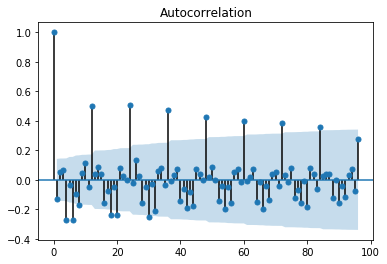

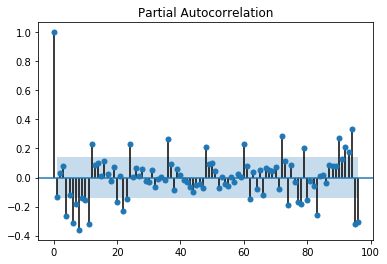

In [54]:
# plot autocorr with statsmodel# plot a 
print(plot_acf(dict_of_dfs[state].Deaths.diff()[1:], lags=96)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(dict_of_dfs[state].Deaths.diff()[1:], lags=96)) # strong PACF lag1 spike, so p=1

In [390]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [391]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
sarima_gridsearch = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dict_of_dfs['California']['mortality_per_100k'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            sarima_gridsearch.append((param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)  

models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}

for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    rmse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.reshape(-1,), y.iloc[test_index].values.reshape(-1,)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        mse_score = -1.0*grid.score(X_test,y_test)
        rmse_score = np.sqrt(mse_score)
        rmse_scores.append(np.round(rmse_score,4))
        avg_mse_score = np.mean(rmse_scores)
        
        s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
        
        grids[name] = grid
        
    print(f'Model name: {name}')
    print(f'RMSE scores: {rmse_scores}')
    print(f'Model RMSE performance: {avg_mse_score}')
    print('\n')